In [16]:
from __future__ import print_function
import os
import sys
sys.path.insert(0, '..')
import gluonbook as gb
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet.gluon.nn import Dense, Activation, Conv2D, Conv2DTranspose, \
    BatchNorm, LeakyReLU, Flatten, HybridSequential, HybridBlock, Dropout
from mxnet import autograd
import numpy as np

In [17]:
epochs = 100
batch_size = 10

ctx = gb.try_gpu()

lr = 0.0002
beta1 = 0.5
lambda1 = 100

pool_size = 50

dataset = 'facades'

In [3]:
img_wd = 256
img_ht = 256
train_img_path = '%s/train' % (dataset)
val_img_path = '%s/val' % (dataset)

def download_data(dataset):
    if not os.path.exists(dataset):
        url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/%s.tar.gz' % (dataset)
        os.mkdir(dataset)
        data_file = utils.download(url)
        with tarfile.open(data_file) as tar:
            tar.extractall(path='.')
        os.remove(data_file)

def load_data(path, batch_size, is_reversed=False):
    img_in_list = []
    img_out_list = []
    for path, _, fnames in os.walk(path):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img).astype(np.float32)/127.5 - 1
            img_arr = mx.image.imresize(img_arr, img_wd * 2, img_ht)
            # Crop input and output images
            img_arr_in, img_arr_out = [mx.image.fixed_crop(img_arr, 0, 0, img_wd, img_ht),
                                       mx.image.fixed_crop(img_arr, img_wd, 0, img_wd, img_ht)]
            img_arr_in, img_arr_out = [nd.transpose(img_arr_in, (2,0,1)),
                                       nd.transpose(img_arr_out, (2,0,1))]
            img_arr_in, img_arr_out = [img_arr_in.reshape((1,) + img_arr_in.shape),
                                       img_arr_out.reshape((1,) + img_arr_out.shape)]
            img_in_list.append(img_arr_out if is_reversed else img_arr_in)
            img_out_list.append(img_arr_in if is_reversed else img_arr_out)

    return mx.io.NDArrayIter(data=[nd.concat(*img_in_list, dim=0), nd.concat(*img_out_list, dim=0)],
                             batch_size=batch_size)

download_data(dataset)
train_data = load_data(train_img_path, batch_size, is_reversed=True)
val_data = load_data(val_img_path, batch_size, is_reversed=True)

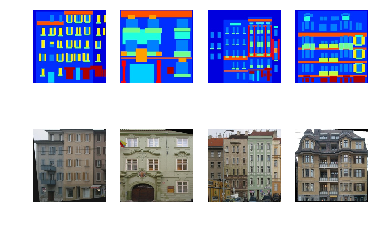

In [4]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

def preview_train_data():
    img_in_list, img_out_list = train_data.next().data
    for i in range(4):
        plt.subplot(2,4,i+1)
        visualize(img_in_list[i])
        plt.subplot(2,4,i+5)
        visualize(img_out_list[i])
    plt.show()

preview_train_data()

In [14]:
class UnetSkipUnit(HybridBlock):
    def __init__(self, inner_channels, outer_channels, inner_block=None, innermost=False, outermost=False,
                 use_dropout=False, use_bias=False):
        super(UnetSkipUnit, self).__init__()

        with self.name_scope():
            self.outermost = outermost
            en_conv = Conv2D(channels=inner_channels, kernel_size=4, strides=2, padding=1,
                             in_channels=outer_channels, use_bias=use_bias)
            en_relu = LeakyReLU(alpha=0.2)
            en_norm = BatchNorm(momentum=0.1, in_channels=inner_channels)
            de_relu = Activation(activation='relu')
            de_norm = BatchNorm(momentum=0.1, in_channels=outer_channels)

            if innermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels, use_bias=use_bias)
                encoder = [en_relu, en_conv]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + decoder
            elif outermost:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2)
                encoder = [en_conv]
                decoder = [de_relu, de_conv, Activation(activation='tanh')]
                model = encoder + [inner_block] + decoder
            else:
                de_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1,
                                          in_channels=inner_channels * 2, use_bias=use_bias)
                encoder = [en_relu, en_conv, en_norm]
                decoder = [de_relu, de_conv, de_norm]
                model = encoder + [inner_block] + decoder
            if use_dropout:
                model += [Dropout(rate=0.5)]

            self.model = HybridSequential()
            with self.model.name_scope():
                for block in model:
                    self.model.add(block)

    def hybrid_forward(self, F, x):
        if self.outermost:
            return self.model(x)
        else:
            return F.concat(self.model(x), x, dim=1)

# Define Unet generator
class UnetGenerator(HybridBlock):
    def __init__(self, in_channels, num_downs, ngf=64, use_dropout=True):
        super(UnetGenerator, self).__init__()

        #Build unet generator structure
        unet = UnetSkipUnit(ngf * 8, ngf * 8, innermost=True)
        for _ in range(num_downs - 5):
            unet = UnetSkipUnit(ngf * 8, ngf * 8, unet, use_dropout=use_dropout)
        unet = UnetSkipUnit(ngf * 8, ngf * 4, unet)
        unet = UnetSkipUnit(ngf * 4, ngf * 2, unet)
        unet = UnetSkipUnit(ngf * 2, ngf * 1, unet)
        unet = UnetSkipUnit(ngf, in_channels, unet, outermost=True)

        with self.name_scope():
            self.model = unet

    def hybrid_forward(self, F, x):
        return self.model(x)

# Define the PatchGAN discriminator
class Discriminator(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_sigmoid=False, use_bias=False):
        super(Discriminator, self).__init__()

        with self.name_scope():
            self.model = HybridSequential()
            kernel_size = 4
            padding = int(np.ceil((kernel_size - 1)/2))
            self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=in_channels))
            self.model.add(LeakyReLU(alpha=0.2))

            nf_mult = 1
            for n in range(1, n_layers):
                nf_mult_prev = nf_mult
                nf_mult = min(2 ** n, 8)
                self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                      padding=padding, in_channels=ndf * nf_mult_prev,
                                      use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
                self.model.add(LeakyReLU(alpha=0.2))

            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n_layers, 8)
            self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult_prev,
                                  use_bias=use_bias))
            self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult))
            self.model.add(LeakyReLU(alpha=0.2))
            self.model.add(Conv2D(channels=1, kernel_size=kernel_size, strides=1,
                                  padding=padding, in_channels=ndf * nf_mult))
            if use_sigmoid:
                self.model.add(Activation(activation='sigmoid'))

    def hybrid_forward(self, F, x):
        out = self.model(x)
        #print(out)
        return out

In [18]:
def param_init(param):
    if param.name.find('conv') != -1:
        if param.name.find('weight') != -1:
            param.initialize(init=mx.init.Normal(0.02), ctx=ctx)
        else:
            param.initialize(init=mx.init.Zero(), ctx=ctx)
    elif param.name.find('batchnorm') != -1:
        param.initialize(init=mx.init.Zero(), ctx=ctx)
        # Initialize gamma from normal distribution with mean 1 and std 0.02
        if param.name.find('gamma') != -1:
            param.set_data(nd.random_normal(1, 0.02, param.data().shape))

def network_init(net):
    for param in net.collect_params().values():
        param_init(param)

def set_network():
    # Pixel2pixel networks
    netG = UnetGenerator(in_channels=3, num_downs=8)
    netD = Discriminator(in_channels=6)

    # Initialize parameters
    network_init(netG)
    network_init(netD)

    # trainer for the generator and the discriminator
    trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

    return netG, netD, trainerG, trainerD

# Loss
GAN_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
L1_loss = gluon.loss.L1Loss()

netG, netD, trainerG, trainerD = set_network()

In [19]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        ret_imgs = []
        for i in range(images.shape[0]):
            image = nd.expand_dims(images[i], axis=0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                ret_imgs.append(image)
            else:
                p = nd.random_uniform(0, 1, shape=(1,)).asscalar()
                if p > 0.5:
                    random_id = nd.random_uniform(0, self.pool_size - 1, shape=(1,)).astype(np.uint8).asscalar()
                    tmp = self.images[random_id].copy()
                    self.images[random_id] = image
                    ret_imgs.append(tmp)
                else:
                    ret_imgs.append(image)
        ret_imgs = nd.concat(*ret_imgs, dim=0)
        return ret_imgs

In [20]:
from datetime import datetime
import time
import logging

def facc(label, pred):
        pred = pred.ravel()
        label = label.ravel()
        return ((pred > 0.5) == label).mean()

def train():
    image_pool = ImagePool(pool_size)
    metric = mx.metric.CustomMetric(facc)

    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)

    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        train_data.reset()
        iter = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x, y)) + log(1 - D(x, G(x, z)))
            ###########################
            real_in = batch.data[0].as_in_context(ctx)
            real_out = batch.data[1].as_in_context(ctx)

            fake_out = netG(real_in)
            fake_concat = image_pool.query(nd.concat(real_in, fake_out, dim=1))
            with autograd.record():
                # Train with fake image
                # Use image pooling to utilize history images
                output = netD(fake_concat)
                fake_label = nd.zeros(output.shape, ctx=ctx)
                errD_fake = GAN_loss(output, fake_label)
                metric.update([fake_label,], [output,])

                # Train with real image
                real_concat = nd.concat(real_in, real_out, dim=1)
                output = netD(real_concat)
                real_label = nd.ones(output.shape, ctx=ctx)
                errD_real = GAN_loss(output, real_label)
                errD = (errD_real + errD_fake) * 0.5
                errD.backward()
                metric.update([real_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(x, G(x, z))) - lambda1 * L1(y, G(x, z))
            ###########################
            with autograd.record():
                fake_out = netG(real_in)
                fake_concat = nd.concat(real_in, fake_out, dim=1)
                output = netD(fake_concat)
                real_label = nd.ones(output.shape, ctx=ctx)
                errG = GAN_loss(output, real_label) + L1_loss(real_out, fake_out) * lambda1
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            # Print log infomation every ten batches
            if iter % 10 == 0:
                name, acc = metric.get()
                logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
                logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                         %(nd.mean(errD).asscalar(),
                           nd.mean(errG).asscalar(), acc, iter, epoch))
            iter = iter + 1
            btic = time.time()

        name, acc = metric.get()
        metric.reset()
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))

        # Visualize one generated image for each epoch
        fake_img = fake_out[0]
        visualize(fake_img)
        plt.show()

train()

INFO:root:speed: 2.608470034869122 samples/s
INFO:root:discriminator loss = 0.854181, generator loss = 42.608814, binary training acc = 0.495061 at iter 0 epoch 0
INFO:root:speed: 0.6288825981530394 samples/s
INFO:root:discriminator loss = 0.651025, generator loss = 40.385929, binary training acc = 0.539885 at iter 10 epoch 0


KeyboardInterrupt: 